In [1]:
import time
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import coffea.processor.accumulator as acc

from awkward import JaggedArray
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import uproot
import uproot_methods 
import awkward
# histogram creation and manipulation
import coffea
import math

In [2]:
# Look at ProcessorABC to see the expected methods and what they are supposed to do
class FancyDimuonProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        mass_axis = hist.Bin("mass", r"$m_{\mu\mu}$ [GeV]", 600, 0.25, 300)
        pt_axis = hist.Bin("pt", r"$p_{T,\mu}$ [GeV]", 3000, 0.25, 300)
        eta_axis = hist.Bin("eta", "Delta_r",300,0,10)

        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("Counts", dataset_axis, mass_axis),
            'mass_near': hist.Hist("Counts", dataset_axis, mass_axis),
            'mass_far': hist.Hist("Counts", dataset_axis, mass_axis),
            'pt_lead': hist.Hist("Counts", dataset_axis, pt_axis),
            'pt_trail': hist.Hist("Counts", dataset_axis, pt_axis),
            'cutflow': processor.defaultdict_accumulator(int),
            'eta':hist.Hist("Counts", dataset_axis,eta_axis)
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()

        dataset = df['dataset']
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'],
            eta=df['Muon_eta'],
            phi=df['Muon_phi'],
            mass=df['Muon_mass'],
            charge=df['Muon_charge'],
            )

        output['cutflow']['all events'] += muons.size


        twomuons = (muons.counts >= 2)
        output['cutflow']['two muons'] += twomuons.sum()

        dimuons = muons[twomuons].distincts()

        twodimuons = (dimuons.counts >= 2)
        output['cutflow']['>= two dimuons'] += twodimuons.sum()
        dimuons = dimuons[twodimuons]

        opposite_charge = (dimuons.i0['charge'] * dimuons.i1['charge'] == -1)

        dimuons = dimuons[opposite_charge]
        output['cutflow']['opposite charge'] += opposite_charge.any().sum()

        mass_20GeV = (dimuons.mass > 35)
        dimuons = dimuons[mass_20GeV]

        exactlytwodimuons = (dimuons.counts == 2)
        output['cutflow']['== two dimuons'] += exactlytwodimuons.sum()
        dimuons = dimuons[exactlytwodimuons].compact()

        leading_mu = (dimuons.i0.pt.content > dimuons.i1.pt.content)
        pt_lead = JaggedArray.fromoffsets(dimuons.offsets, np.where(leading_mu,
                                                                    dimuons.i0.pt.content, dimuons.i1.pt.content))
        pt_trail = JaggedArray.fromoffsets(dimuons.offsets, np.where(~leading_mu,
                                                                     dimuons.i0.pt.content, dimuons.i1.pt.content))
        ls = dimuons.i0.p4.delta_r(other = dimuons.i1.p4)
        ls = ls.flatten()
        near_z = np.abs(dimuons.mass - 91.118).argmin()
        far_z = np.abs(dimuons.mass - 91.118).argmax()
        vals=np.array(dimuons)
        output['mass'].fill(dataset=dataset,
                            mass=dimuons.p4.sum().mass)
        output['mass_near'].fill(dataset=dataset,
                                 mass=dimuons.mass[near_z].flatten())
        output['mass_far'].fill(dataset=dataset,
                                mass=dimuons.mass[far_z].flatten())
        output['pt_lead'].fill(dataset=dataset,
                               pt=pt_lead.flatten())
        output['pt_trail'].fill(dataset=dataset,
                                pt=pt_trail.flatten())
        output['eta'].fill(dataset=dataset, eta = ls.flatten())
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
tstart = time.time()

fileset = {
    'DoubleMuon': ['Run2012BC_DoubleMuParked_Muons.root']
}
output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=FancyDimuonProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 6, 'flatten': True},
                                  chunksize=100000,
                                 )

elapsed = time.time() - tstart
print(output)


{'mass': <Hist (dataset,mass) instance at 0x257a5d53c08>, 'mass_near': <Hist (dataset,mass) instance at 0x257a491e1c8>, 'mass_far': <Hist (dataset,mass) instance at 0x257a5d40988>, 'pt_lead': <Hist (dataset,pt) instance at 0x257a457ea88>, 'pt_trail': <Hist (dataset,pt) instance at 0x257a487da48>, 'cutflow': defaultdict_accumulator(<class 'int'>, {'all events': 61540413, 'two muons': 53271246, '>= two dimuons': 22166903, 'opposite charge': 19153437, '== two dimuons': 1710818}), 'eta': <Hist (dataset,eta) instance at 0x257a5c11f08>}


In [4]:
print(output['cutflow'])

defaultdict_accumulator(<class 'int'>, {'all events': 61540413, 'two muons': 53271246, '>= two dimuons': 22166903, 'opposite charge': 19153437, '== two dimuons': 1710818})


<Hist (dataset,mass) instance at 0x257a5d53c08>


C:\Users\zshel\miniconda3\lib\site-packages\mplhep\_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


TypeError: cannot unpack non-iterable AxesSubplot object

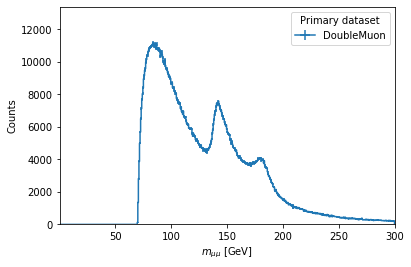

In [5]:
print(output['mass'])
fig, ax, _ = hist.plot1d(output['mass'], overlay='dataset')
ax.set_xlim(70,150)
ax.set_ylim(0, 3000)

C:\Users\zshel\miniconda3\lib\site-packages\mplhep\_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


TypeError: cannot unpack non-iterable AxesSubplot object

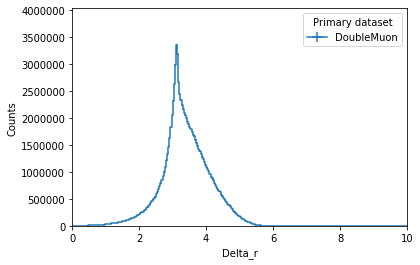

In [43]:
fig, ax, _ = hist.plot1d(output['eta'], overlay='dataset',binwnorm =True)

C:\Users\zshel\miniconda3\lib\site-packages\mplhep\_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


TypeError: cannot unpack non-iterable AxesSubplot object

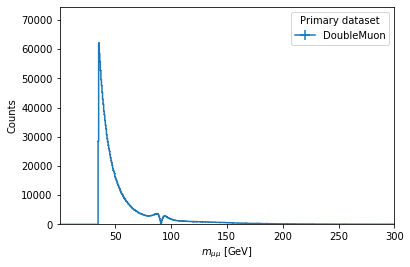

In [37]:
fig, ax, _ = hist.plot1d(output['mass_far'], overlay='dataset')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(60,120)
ax.set_ylim(0.1, 7500)



C:\Users\zshel\miniconda3\lib\site-packages\mplhep\_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


TypeError: cannot unpack non-iterable AxesSubplot object

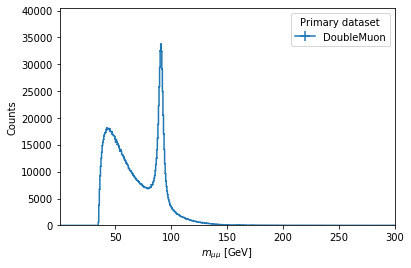

In [38]:
fig, ax, _ = hist.plot1d(output['mass_near'], overlay='dataset')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(60,120)
ax.set_ylim(0.1, 7500)

C:\Users\zshel\miniconda3\lib\site-packages\mplhep\_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


TypeError: cannot unpack non-iterable AxesSubplot object

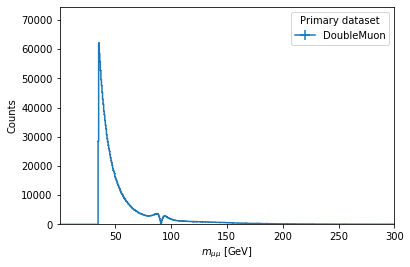

In [39]:
fig, ax, _ = hist.plot1d(output['mass_far'], overlay='dataset')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim(0.1, 8000)

C:\Users\zshel\miniconda3\lib\site-packages\mplhep\_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


TypeError: cannot unpack non-iterable AxesSubplot object

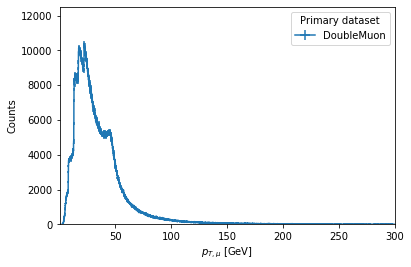

In [40]:
fig, ax, _ = hist.plot1d(output['pt_lead'], overlay='dataset')
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.1, 5e3)

C:\Users\zshel\miniconda3\lib\site-packages\mplhep\_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


TypeError: cannot unpack non-iterable AxesSubplot object

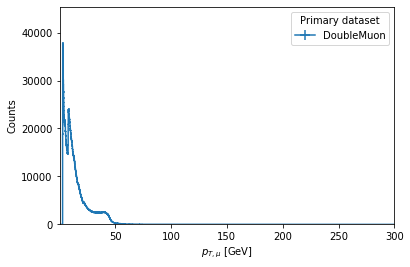

In [41]:
fig, ax, _ = hist.plot1d(output['pt_trail'], overlay='dataset')
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.1, 2e4)

In [31]:
print("Events/s:", output['cutflow']['all events']/elapsed)

Events/s: 481357.3075518068


In [34]:
import torch